**Import libraries:**

In [1]:
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.interpolate import interp1d

# Step 1:
# Model of LiFePO4 Batteries

**To model LiFePO4 batteries in PyBaMM:** 
1. choose an existing model 
2. a set of parameters that are appropriate for LiFePO4 chemistry

- PyBaMM provides several parameter sets for lithium-ion batteries, some of which are suitable for LiFePO4 cells.

**Select a model from PyBaMM's library**

- For LiFePO4 batteries, a common choice is the Doyle-Fuller-Newman (DFN) model, which is a detailed physics-based model that includes solid and electrolyte diffusion, electrochemical reactions, and thermal effects.


In [2]:
# Choose a model
model = pybamm.lithium_ion.DFN()

**Select a Parameter Set**

- Choose a parameter set that is designed for LiFePO4 chemistry.

In [3]:
# Choose a parameter set
parameter_values = pybamm.ParameterValues("Chen2020")
# parameter_values.update({"Positive electrode OCV [V]": "[path to your data]"})

**Define an Experiment or a Drive Cycle**

- Define the charging and operating conditions for the simulation.

In [5]:
# Define an experiment or drive cycle
experiment = pybamm.Experiment(
    [
        "Discharge at C/5 for 10 hours or until 2.5 V",
        "Charge at 1 A until 4.2 V",
        "Hold at 4.2 V until 10 mA"
    ])

**Set Up and Run the Simulation**

- Set up the simulation with the model, parameter values, and experiment.

In [6]:
# Set up and run the simulation
sim = pybamm.Simulation(
    model,
    parameter_values=parameter_values,
    experiment=experiment
)
# If initial SOC is not set, the default is 50%
sim.solve()

**Plot Results or Output Data**

- Plot:

interactive(children=(FloatSlider(value=0.0, description='t', max=11.980177636308134, step=0.11980177636308134…

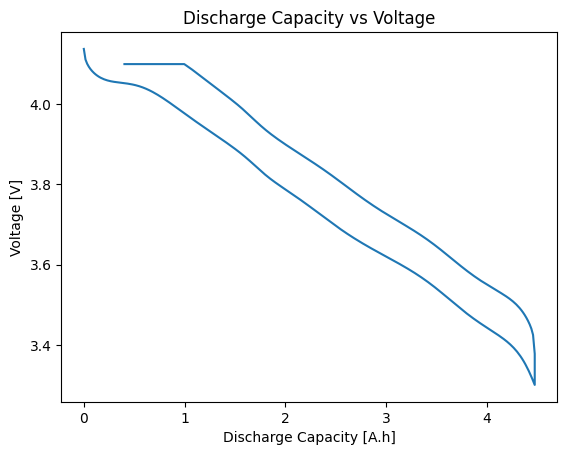

In [9]:
# Plot the results
sim.plot()

# Or output data to a pandas DataFrame
solution = sim.solution
time = solution["Time [s]"].entries
voltage = solution["Terminal voltage [V]"].entries
current = solution["Current [A]"].entries
SOC = solution["Discharge capacity [A.h]"].entries
# Add more variables as needed

discharge_capacity = solution["Discharge capacity [A.h]"].data
voltage = solution["Voltage [V]"].data

# Create a plot
fig, ax = plt.subplots()
ax.plot(discharge_capacity, voltage)

# Add labels and a title
ax.set_xlabel("Discharge Capacity [A.h]")
ax.set_ylabel("Voltage [V]")
ax.set_title("Discharge Capacity vs Voltage")

# Show the plot
plt.show()

- Saving data

In [10]:
# Create a DataFrame
data = {
    "Time [s]": time,
    "Voltage [V]": voltage,
    "Current [A]": current,
    "Discharge capacity [A.h]": SOC,
    # Include other variables here
}
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
df.to_excel("battery_data.xlsx")

# Step 2:
# EV charging profile

- An EV charging profile often includes stages of **constant current (CC) charging followed by constant voltage (CV) charging**. The specific parameters for these stages can vary depending on the vehicle's charging hardware and the battery's specifications.

- **Constant Current (CC) Charging:** This stage involves charging the battery at a constant current until a certain voltage threshold is reached. For example, charging at 1C (where 1C is the current that would fully charge the battery in one hour) until the battery voltage reaches 4.2 V.

- **Constant Voltage (CV) Charging:** Once the voltage threshold is reached, the charger switches to constant voltage mode, where the voltage is held constant and the current gradually decreases. This stage continues until the charging current drops below a certain level, indicating that the battery is nearly full.

- **Rest or Cool-down Period:** After charging, there might be a rest or cool-down period before the battery is used again.

In [9]:
# Choose a model and parameter set
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues(values=pybamm.parameter_sets.Chen2020)

# Define a modified experiment
experiment = pybamm.Experiment(
    [
        "Rest for 10 minutes",           # Start with a rest period
        "Charge at 1 C until 4.2 V",     # CC stage
        "Hold at 4.2 V until 50 mA",     # CV stage
        "Rest for 1 hour"                # Rest period after charging
    ],
    period="1 second"
)

# Set up the simulation
sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=experiment)

# Solve the simulation with an appropriate initial SOC
sim.solve(initial_soc=0.3)  # Adjust this value based on your battery's characteristics

# Plot the results
sim.plot()


interactive(children=(FloatSlider(value=0.0, description='t', max=3.0458304658516013, step=0.03045830465851601…

# Step 3:
# Second-life Battery with degredation Model 
- Save Model Characteristics at 80% State of Health (SOH)

- **Model with degredation**

In [2]:
# Set model options for SEI degradation
options = {
    "SEI": "reaction limited",  
    "thermal":"lumped",
    "cell geometry": "arbitrary",
    "SEI": "solvent-diffusion limited",
    "SEI porosity change": "true",
}

# Update the model with the chosen options
model_with_deg = pybamm.lithium_ion.DFN(options)

- **Parameter set**

In [3]:
# Choose a parameter set
parameter_values = pybamm.ParameterValues("Chen2020")

- **Solver**

In [4]:
solver = pybamm.CasadiSolver(mode="safe", max_step_decrease_count=15)

- **Number of cycles**

In [7]:
num_cycles = 2  # Number of cycles

- **Experiments**

In [8]:
# Experiment from First Snippet
experiment = pybamm.Experiment(
    [
        "Rest for 10 minutes",
        "Charge at 1 C until 4.2 V",
        "Hold at 4.2 V until 50 mA",
        "Rest for 1 hour",
        "Discharge at 1 C until 2.5 V",
        "Rest for 1 hour",
    ] * num_cycles,
    period="1 second"
)

**Run simulation:**

1. Run an initial capacity simulation without degradation ==>  determine the **battery's initial capacity**.

In [9]:
# Run First Simulation
deg_sim = pybamm.Simulation(model_with_deg, parameter_values=parameter_values, experiment=experiment, solver=solver)
deg_solution = deg_sim.solve(initial_soc=0.3)
initial_capacity = deg_solution.summary_variables["Capacity [A.h]"][-1]

2. Set up a second simulation with the **degradation model**.

3. After each step, calculate the current capacity and SOH.

4. Continue the simulation until the SOH reaches 80%.

5. Save the battery model parameters and the relevant data at the point where SOH reaches 80%.

6. Save battery parameters

7. Apply another Ch/Dis profile

In [10]:
# Initialize SOH Storage
initial_soc = 0.3
soh_over_cycles = []
all_cycles_data = []
Cycle_data = []
# Secondary Simulation with Dynamic Experiment Parameters
for cycle_N in range(1, num_cycles + 1):

    deg_solution = deg_sim.solve()

    # Update Capacity and SOH for each cycle
    current_capacity = deg_solution.summary_variables["Capacity [A.h]"][-1]
    SOH = current_capacity / initial_capacity * 100
    soh_over_cycles.append(SOH)

    # Extract data for this cycle
    times = deg_solution["Time [s]"].entries
    voltage = deg_solution["Terminal voltage [V]"].entries
    current = deg_solution["Current [A]"].entries
    cycle_numbers = [cycle_N] * len(times)
    soh = [soh_over_cycles[cycle_N-1]] * len(times)  # Repeat SOH for each time point

    dt = np.diff(times, prepend=times[0])  # Time differences for integration
    # Initialize SoC array
    soc = np.zeros_like(times)
    soc[0] = initial_soc
    # Calculate SoC at each time step
    for i in range(1, len(times)):
        charge_added = current[i] * dt[i] / 3600  # Convert to Ah
        soc[i] = soc[i-1] + charge_added / current_capacity
        soc[i] = max(0, min(soc[i], 1))  # Ensure SoC stays within 0 and 1

    # Create a DataFrame for this cycle
    cycle_data = pd.DataFrame({
        "Time [s]": times,
        "Cycle": cycle_numbers,
        "Voltage [V]": voltage,
        "Current [A]": current,
        "State of Charge": soc,
        # "Temperature [K]": temperature,
        "SOH": soh
    })
    all_cycles_data.append(cycle_data)

    # Dynamic Parameters
    lower_SoC = 0.3  # Lower State of Charge
    upper_SoC = 0.7  # Upper State of Charge
    C_rate_charge = 1  # C-rate for charging
    C_rate_discharge = 1  # C-rate for discharging

    charging_current = C_rate_charge * current_capacity  # A
    discharging_current = C_rate_discharge * current_capacity  # A
    initial_lower_Q = lower_SoC * current_capacity  # Ah
    initial_upper_Q = upper_SoC * current_capacity  # Ah
    charge_time = (initial_upper_Q - initial_lower_Q) / charging_current  # h
    discharge_time = (initial_upper_Q - initial_lower_Q) / discharging_current  # h

    # Define the experiment for this cycle
    experiment_N_1 = pybamm.Experiment([
        f"Charge at {charging_current} A until 4.2 V",
        "Hold at 4.2 V for 1 hours",  # Hold step for safety
        f"Discharge at {discharging_current} A until 2.5 V",
        "Hold at 2.5 V for 1 hours"  # Hold step for safety
        # Add other steps as necessary
    ])

    # Run the simulation for this cycle
    SPMe = pybamm.lithium_ion.SPMe(options={"SEI": "reaction limited"})
    sim = pybamm.Simulation(SPMe, parameter_values=parameter_values, experiment=experiment_N_1, solver=solver)

    # Solve the simulation with initial SoC check
    if lower_SoC >= 0 and lower_SoC <= 1:
        if cycle_N == 1:
            deg_solution = sim.solve(initial_soc=lower_SoC)
        else:
            deg_solution = sim.solve(starting_solution=deg_solution)  # Continue from the previous solution
    else:
        raise ValueError("Initial SoC is out of feasible range (0-1)")

**Saving data:**

In [11]:
combined_data = pd.DataFrame(cycle_data)
combined_data.to_excel("battery_data.xlsx")